In [2]:
import cv2
import matplotlib.pyplot as plt
from cv2.typing import *
import numpy as np


def load_image():
    image = cv2.imread("images/image.png")
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


def display_image(image: MatLike, title: str):
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')  # Turn off the axis
    plt.show()


def quantize_image(image: MatLike, n_colors):
    Z = image.reshape((-1, 3))
    # convert to np.float32
    Z = np.float32(Z)
    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    ret, label, center = cv2.kmeans(
        Z, n_colors, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    res = center[label.flatten()]
    final_image = res.reshape((image.shape))

    return final_image

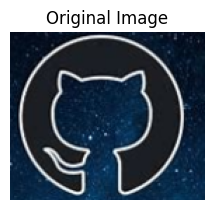

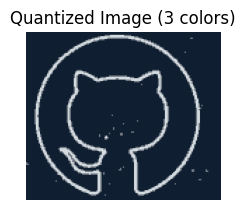

In [7]:
colors = 3
quantized_image = quantize_image(load_image(), colors)

plt.figure(1)
plt.subplot(223)
display_image(load_image(), 'Original Image')

plt.figure(2)
plt.subplot(223)
display_image(quantized_image, f'Quantized Image ({colors} colors)')

In [11]:

image_array = np.array(load_image())
i = 0
colours={}
num_rows, num_columns, other = image_array.shape
print("Number of rows:", num_rows)
print("Number of columns:", num_columns)


Number of rows: 120
Number of columns: 139


In [13]:
def get_colors(image_array, height, width):
    colors = {}
    i = 0
    j=0
    while i<width:
        while j<height:
            
            pixel = str(image_array[i,j]) 
            if pixel in colors:
                colors[pixel]= colors[pixel]+1
            else:
                colors[pixel]=1
            j = j+1
        j=0
        i = i+1
    return colors

def get_pallete(colors, percentaje, height, width):
    pallete = {}
    for color in colors.keys():
        if colors[color]/(height*width) > percentaje:
            pallete[color]= colors[color]
    return pallete

In [14]:
colores = get_colors(image_array, num_columns, num_rows)
print(colores)

{'[ 3 10 26]': 3, '[ 2  9 25]': 6, '[ 4 11 27]': 3, '[ 1  7 23]': 6, '[ 4 10 26]': 3, '[ 1  6 22]': 1, '[ 3  9 25]': 4, '[12 18 34]': 1, '[14 20 36]': 2, '[11 17 33]': 2, '[10 16 32]': 4, '[10 17 33]': 2, '[20 31 47]': 3, '[14 27 42]': 3, '[ 5 17 33]': 8, '[ 1 13 29]': 5, '[ 0 10 26]': 3, '[15 23 40]': 1, '[34 42 60]': 1, '[18 25 44]': 1, '[ 1  4 23]': 1, '[14 19 38]': 1, '[13 21 41]': 1, '[ 6 16 36]': 1, '[ 5 18 37]': 12, '[ 0 13 32]': 4, '[ 0 14 32]': 1, '[13 29 46]': 1, '[52 67 85]': 1, '[57 68 88]': 1, '[10 20 40]': 1, '[ 3 13 32]': 3, '[ 0 15 33]': 2, '[ 1 16 34]': 2, '[ 1 16 33]': 1, '[ 3 18 35]': 2, '[14 30 46]': 2, '[15 30 46]': 1, '[ 3 16 32]': 9, '[ 7 18 34]': 5, '[25 33 49]': 1, '[19 26 42]': 1, '[ 8 14 31]': 1, '[13 20 37]': 3, '[16 24 42]': 1, '[15 23 42]': 1, '[ 7 15 34]': 1, '[ 2  9 28]': 2, '[ 8 16 35]': 4, '[ 2 10 29]': 4, '[ 4 12 31]': 5, '[ 0  5 24]': 1, '[ 3  7 26]': 1, '[ 2  5 24]': 2, '[ 1  2 22]': 1, '[ 0  2 21]': 1, '[ 1  3 22]': 2, '[ 3  8 27]': 1, '[ 3 10 29]'